In [2]:
languages = ["en", "ar", "he", "nl", "fy", "hi", "ur", "sw", "zu", "cy", "gd"]

# Make a mapping from language code to full language name:
language_names = {
    "en": "English",
    "ar": "Arabic",
    "he": "Hebrew",
    "nl": "Dutch",
    "fy": "Frisian",
    "hi": "Hindi",
    "ur": "Urdu",
    "sw": "Swahili",
    "zu": "Zulu",
    "cy": "Welsh",
    "gd": "Scottish Gaelic",
}

masks_path = "../masks"

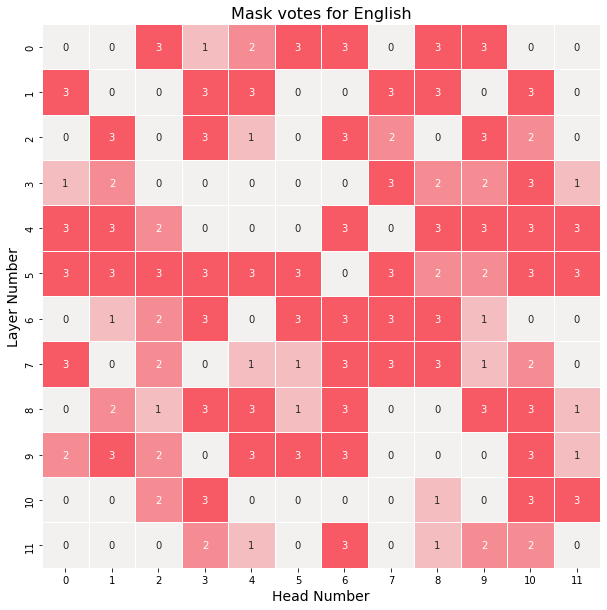

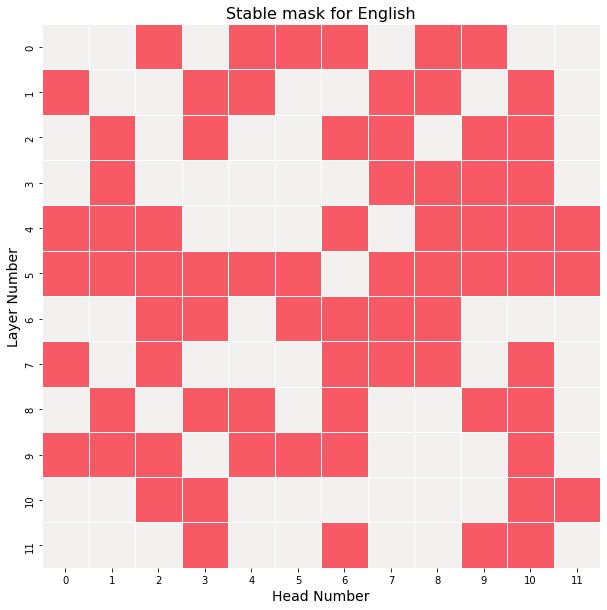

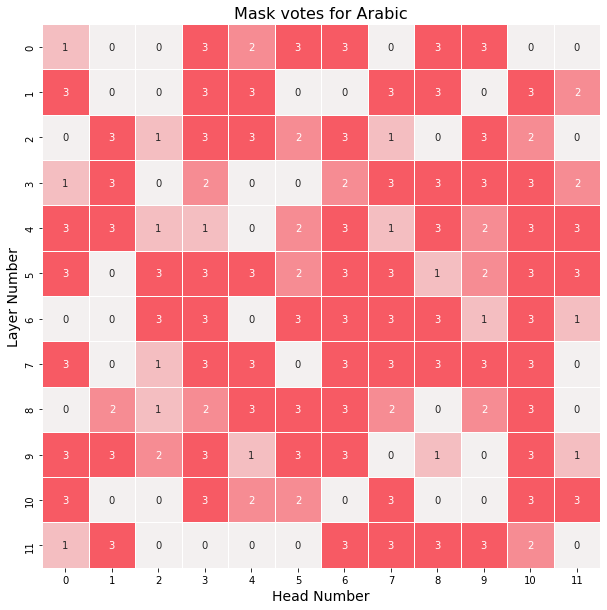

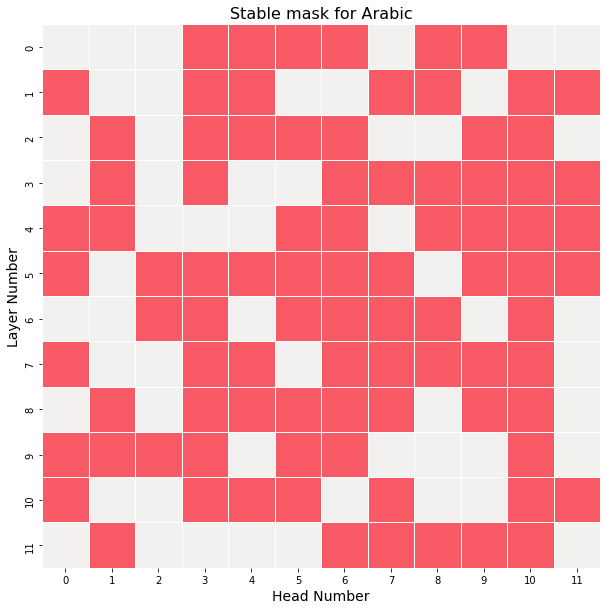

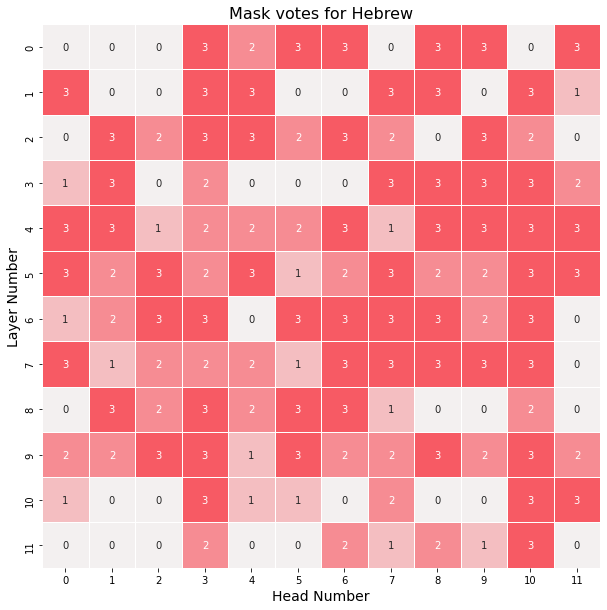

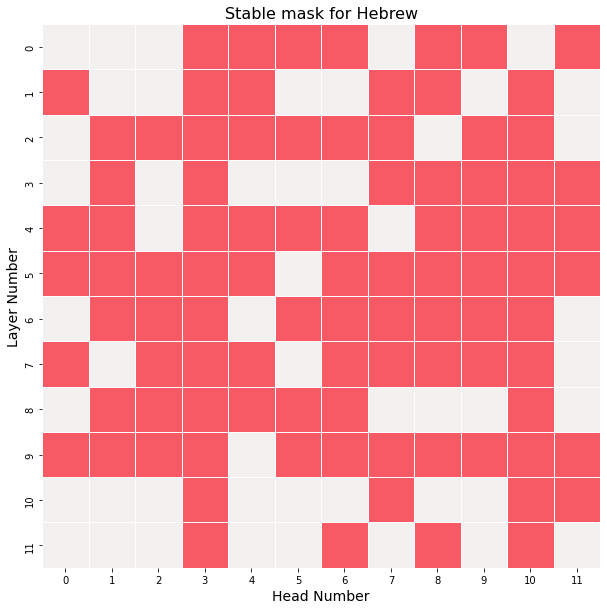

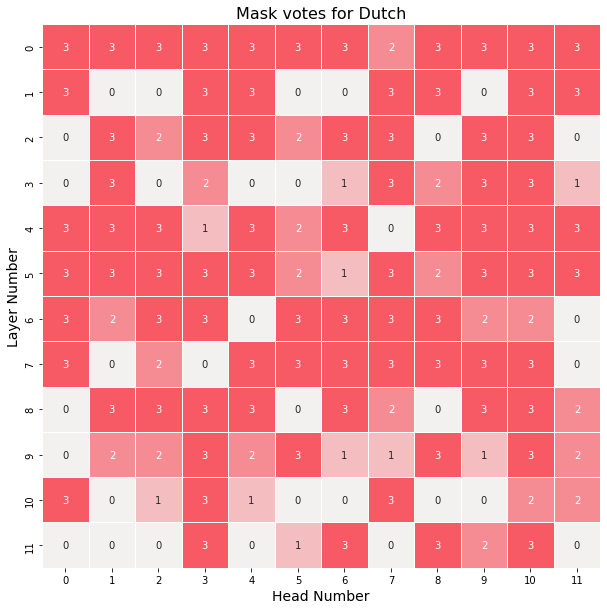

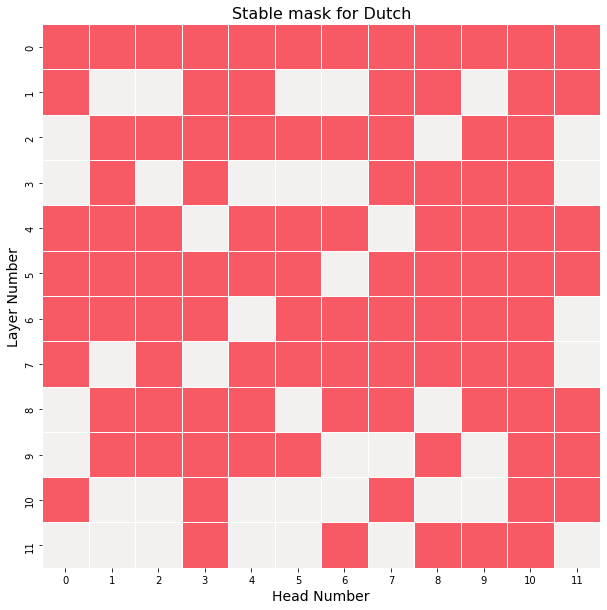

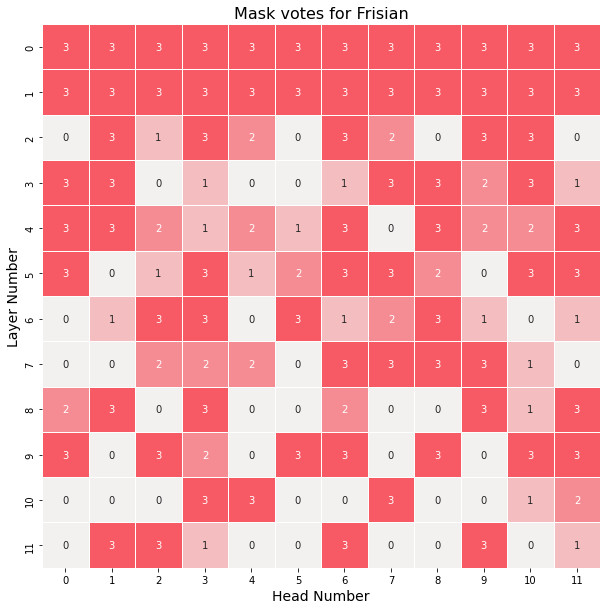

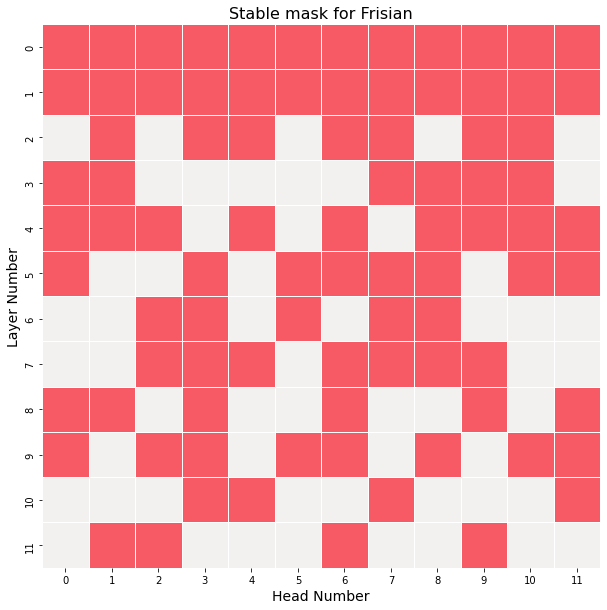

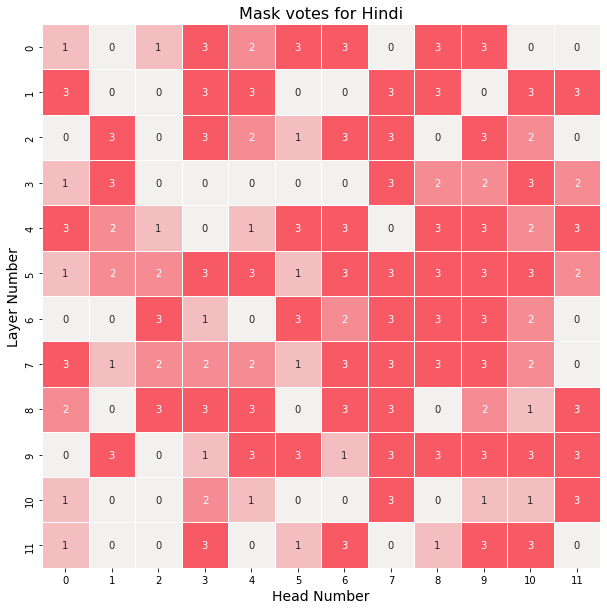

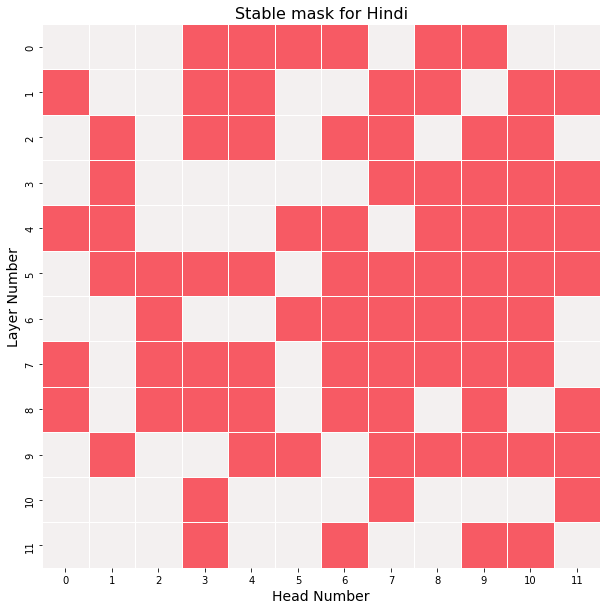

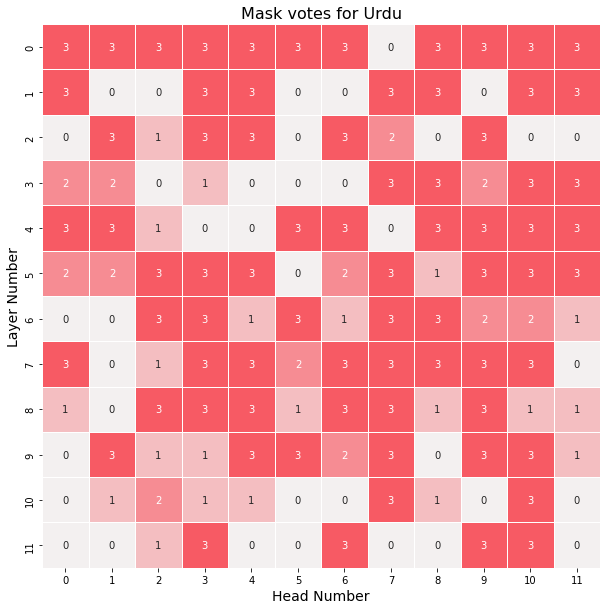

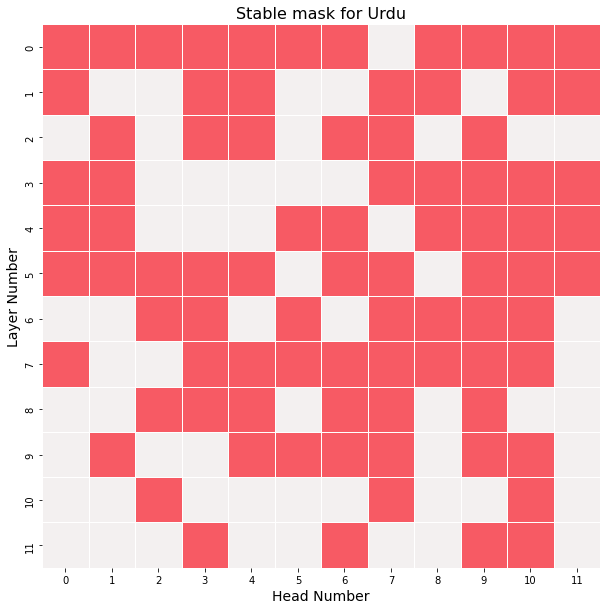

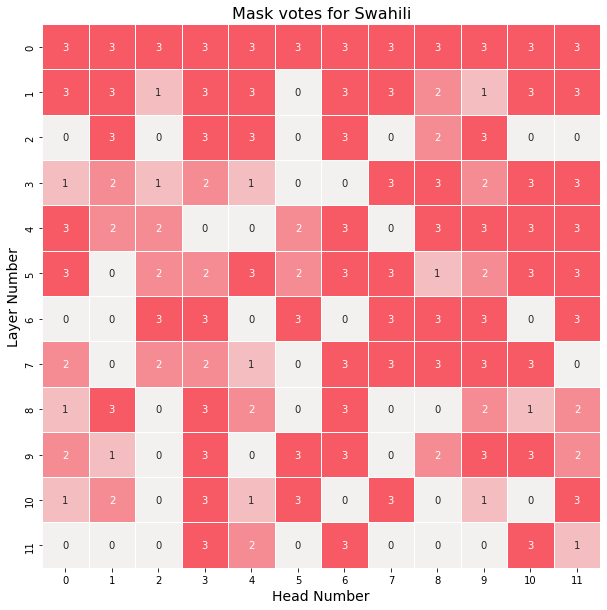

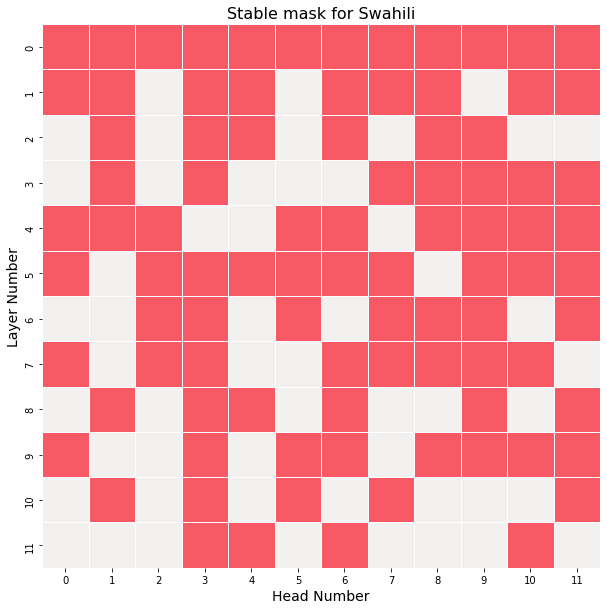

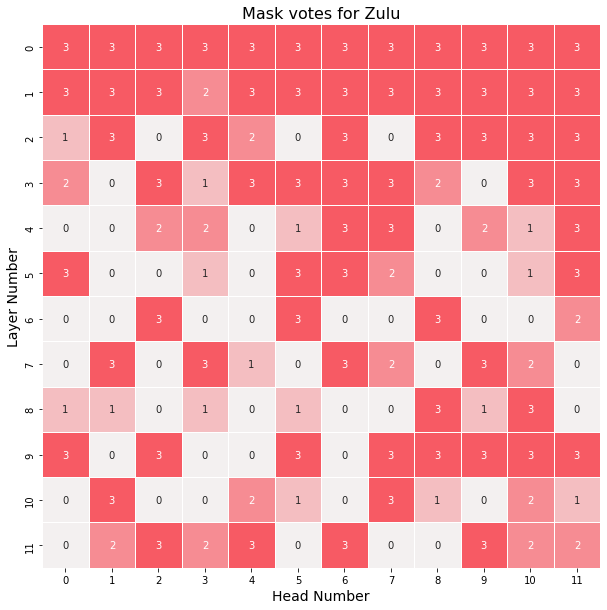

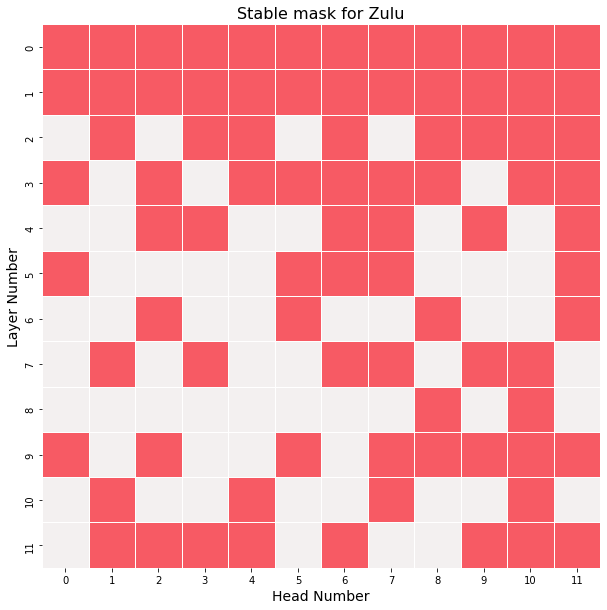

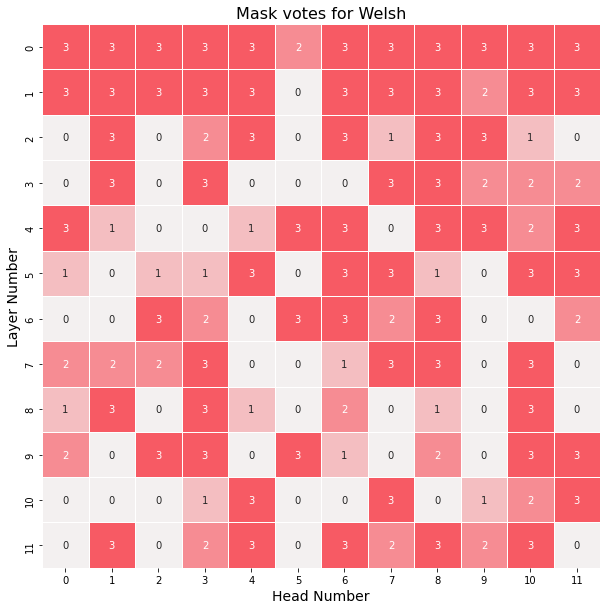

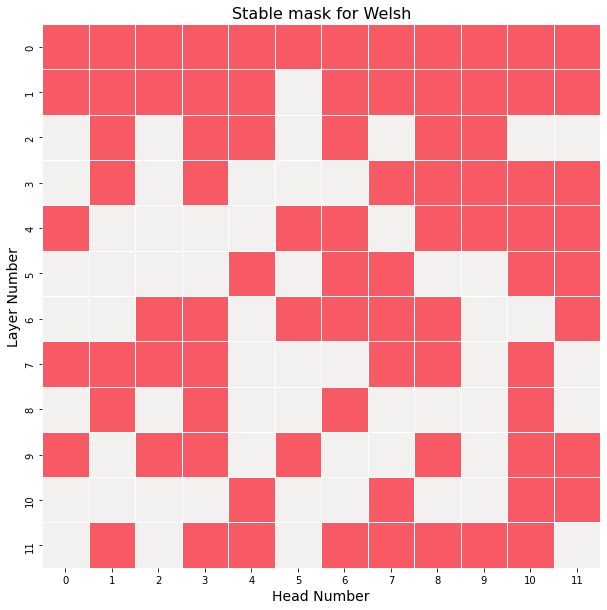

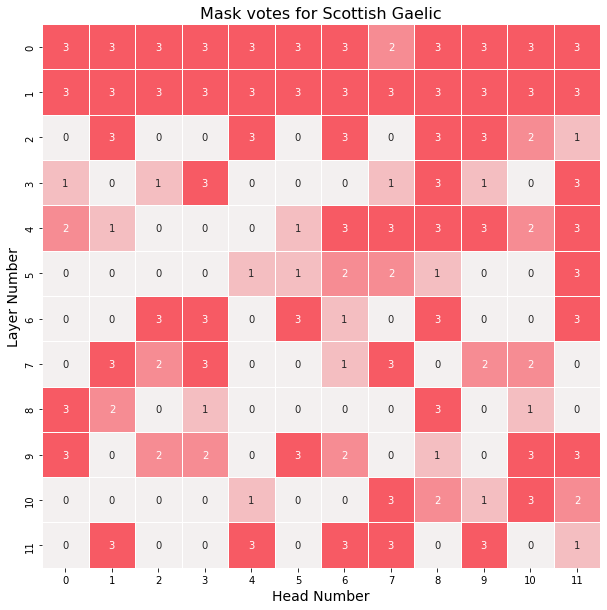

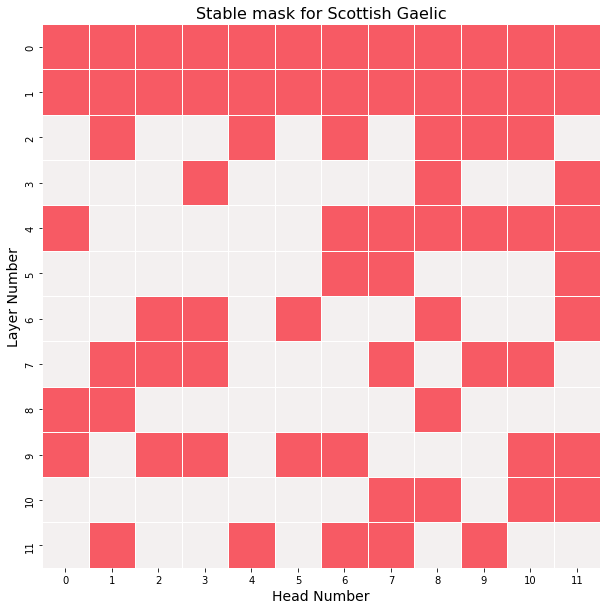

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_masks(language, figure_size=(10, 10)):
    # Load masks based on language and seeds
    # Cross-Lingual-Subnetwork-Analysis\masks\head_masks\head_mask_ar_1.npy
    head_mask_1 = np.load(f"{masks_path}/head_masks\head_mask_{language}_1.npy")
    head_mask_2 = np.load(f"{masks_path}/head_masks/head_mask_{language}_2.npy")
    head_mask_3 = np.load(f"{masks_path}/head_masks/head_mask_{language}_3.npy")

    # Sum the masks
    sum_mask = head_mask_1 + head_mask_2 + head_mask_3

    # Set up a figure with a larger size and higher resolution
    fig, ax = plt.subplots(figsize=figure_size)
    cmap = sns.light_palette((10, 90, 60), input="husl", as_cmap=True)

    # Plot the summed mask with darker colors indicating a higher number of votes
    sns.heatmap(sum_mask, cmap=cmap, ax=ax, cbar=True, annot=True, linewidths=0.5)
    ax.set_title(f'Mask votes for {language_names[language]}', fontsize=16)
    ax.set_xlabel("Head Number", fontsize=14)
    ax.set_ylabel("Layer Number", fontsize=14)
    ax.collections[0].colorbar.remove()
    # Save the figure in a high-quality format
    plt.savefig(f'mask_figures/sum_mask_{language}.pdf', bbox_inches='tight', dpi=300)

    # Show the figure
    plt.show()

    # Through a voting mechanism, at least two votes determine the state of a head.
    combined_mask = sum_mask >= 2

    # Set up a new figure
    fig, ax = plt.subplots(figsize=figure_size)

    # Plot the combined mask
    sns.heatmap(combined_mask, cmap=cmap, ax=ax, cbar=True, linewidths=0.5)
    ax.set_title(f'Stable mask for {language_names[language]}', fontsize=16)
    ax.set_xlabel("Head Number", fontsize=14)
    ax.set_ylabel("Layer Number", fontsize=14)
    # plt.axis('off')  # hide the axis
    
    ax.collections[0].colorbar.remove()


    # Save the figure in a high-quality format
    plt.savefig(f'mask_figures/combined_mask_{language}.pdf', bbox_inches='tight', dpi=300)

    # Show the figure
    plt.show()

# Use the function for language in ar, en, fy, he, hi, nl 
for language in languages:
    plot_masks(language)


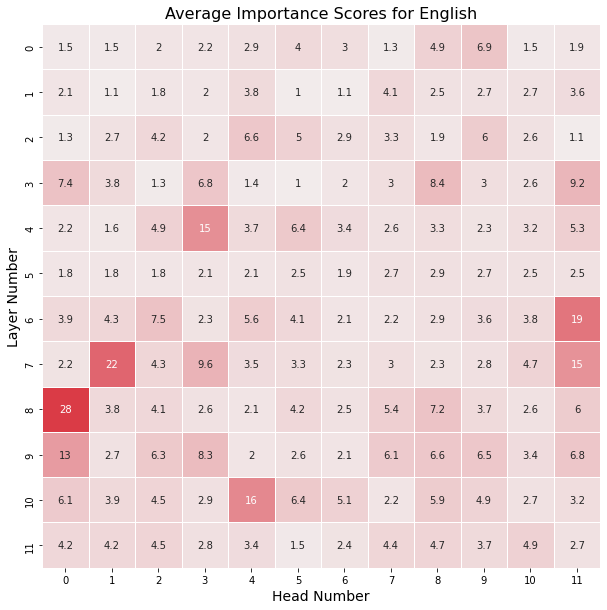

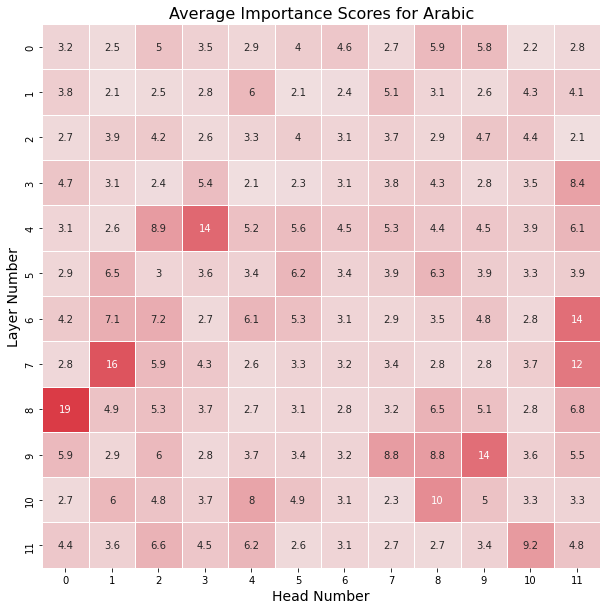

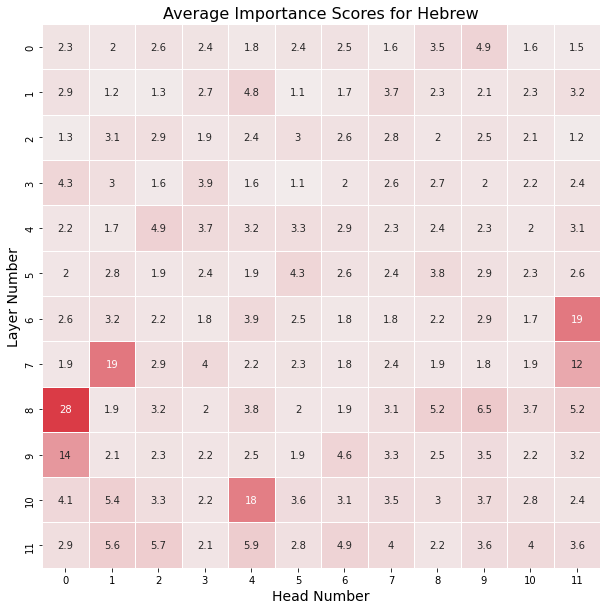

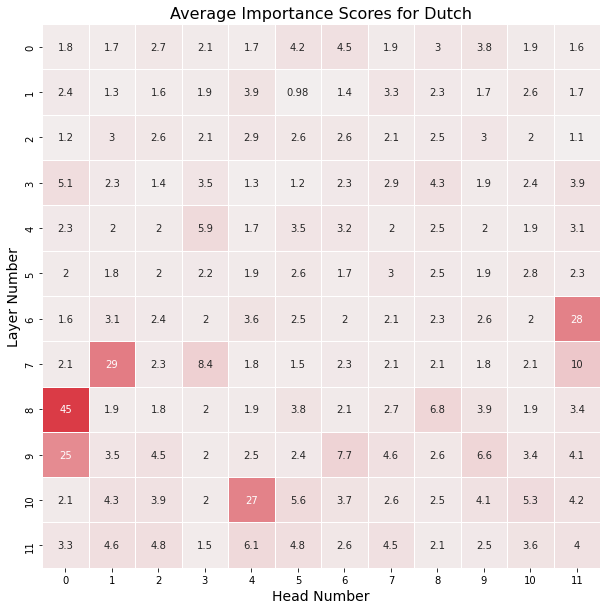

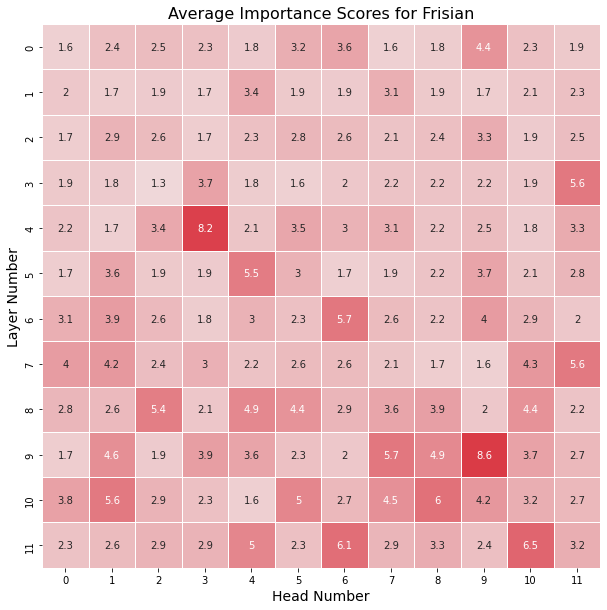

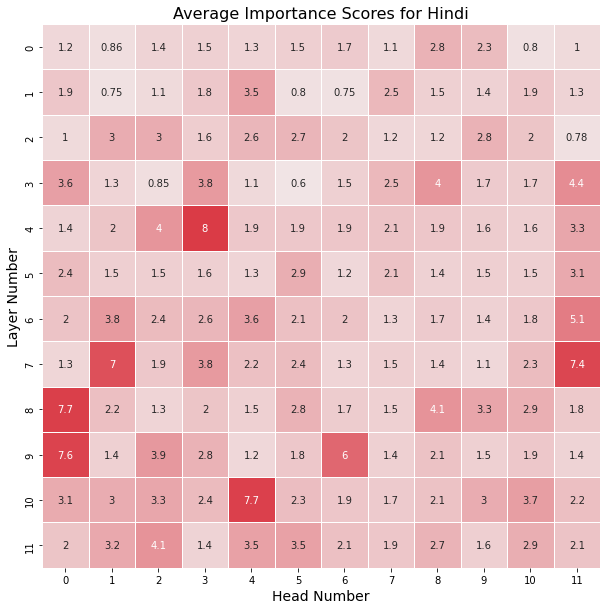

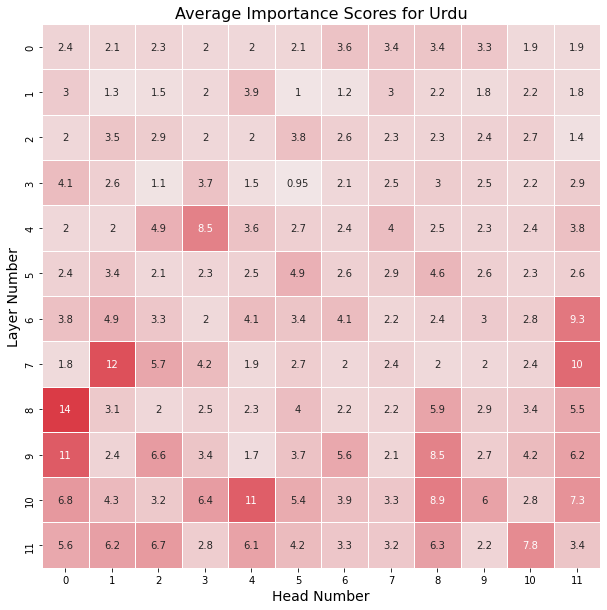

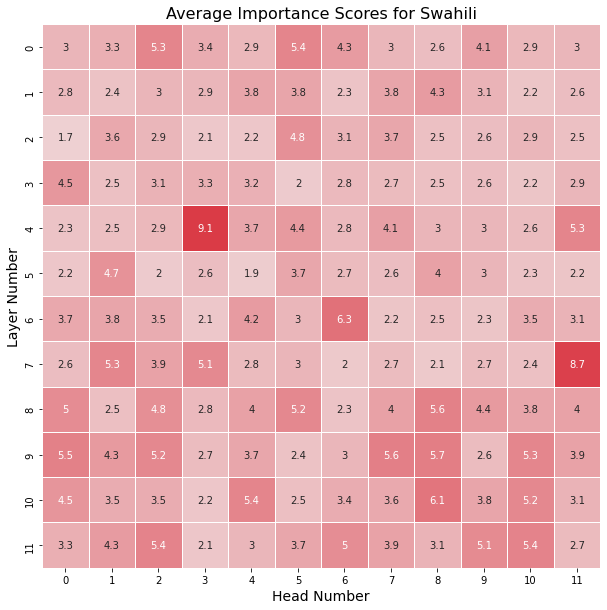

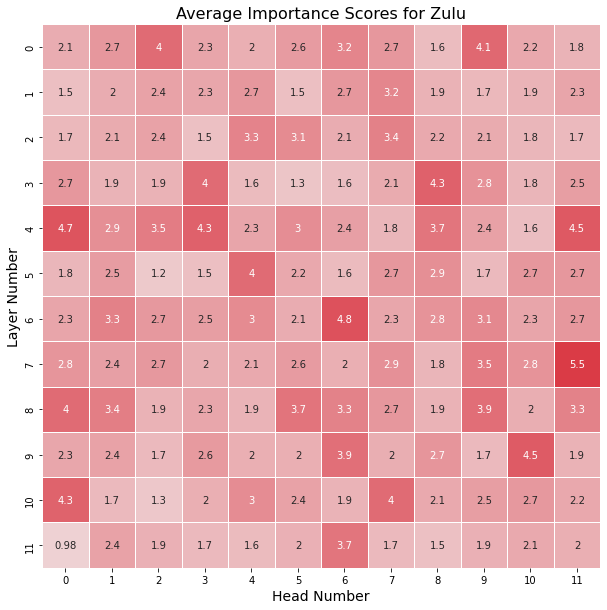

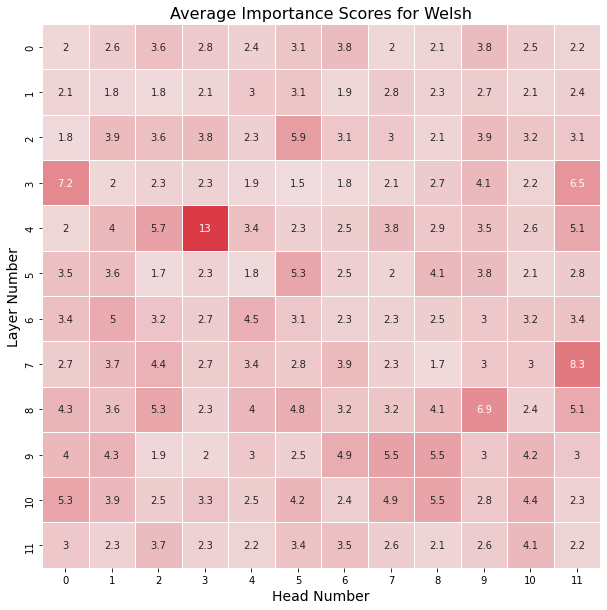

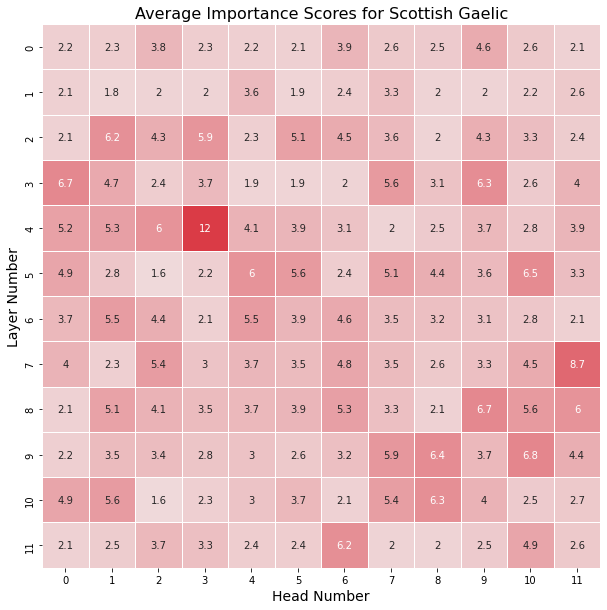

In [19]:
def plot_importance_scores(language, directory=f"{masks_path}/importance_scores/", figure_size=(10, 10), vmax=45):
    # Load the importance scores for the given language and seeds
    importance_scores_1 = np.load(f"{directory}/importance_scores_{language}_1.npy")
    importance_scores_2 = np.load(f"{directory}/importance_scores_{language}_2.npy")
    importance_scores_3 = np.load(f"{directory}/importance_scores_{language}_3.npy")

    # Average the importance scores
    average_importance_scores = (importance_scores_1 + importance_scores_2 + importance_scores_3) / 3

    # Set up a figure with a larger size
    fig, ax = plt.subplots(figsize=figure_size)

    # Define the colormap
    cmap = sns.diverging_palette(220, 10, sep=1, as_cmap=True)

    # Plot the average importance scores using seaborn's heatmap function
    sns.heatmap(average_importance_scores, 
                annot=True, 
                cmap=cmap, 
                ax=ax, 
                cbar=False, 
                center=0, 
                # vmax=vmax, quick explanation: here we don't want a global maximum because for pruning we want to prune the heads with the lowest scores relative to their own importance scores
                linewidths=0.5
    )

    # Set title and labels
    ax.set_title(f'Average Importance Scores for {language_names[language]}', fontsize=16)
    ax.set_xlabel("Head Number", fontsize=14)
    ax.set_ylabel("Layer Number", fontsize=14)

    # Save the figure in a high-quality format
    plt.savefig(f'mask_figures/importance_scores_{language}.pdf', bbox_inches='tight', dpi=300)

    # Show the figure
    plt.show()

# Use the function for language in ar, en, fy, he, hi, nl
for language in languages:
    plot_importance_scores(language)


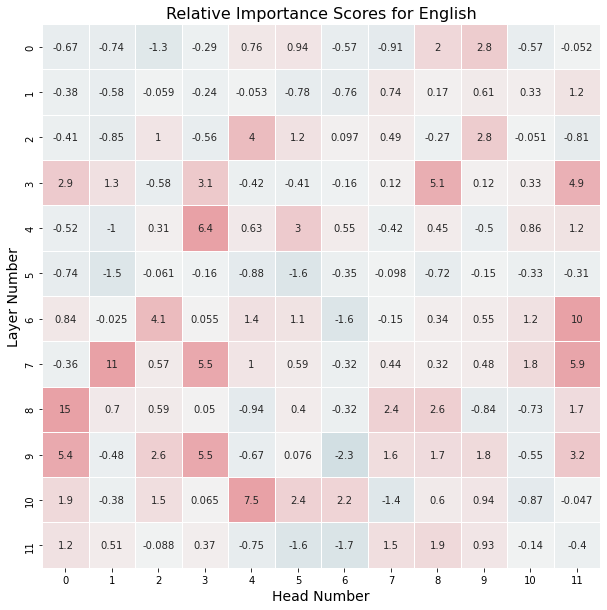

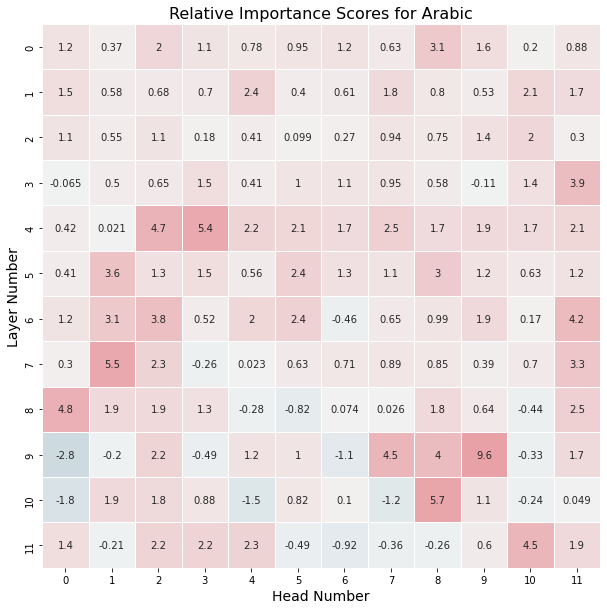

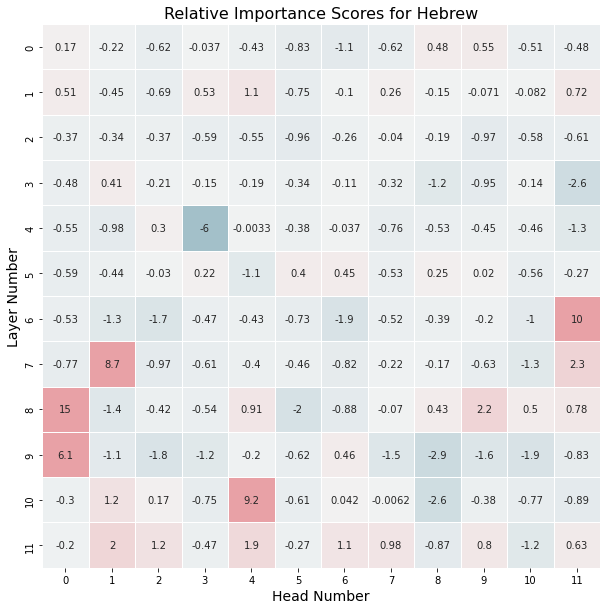

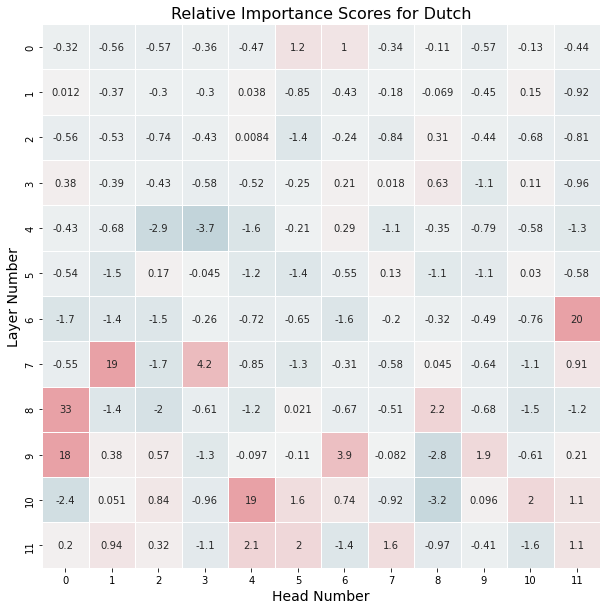

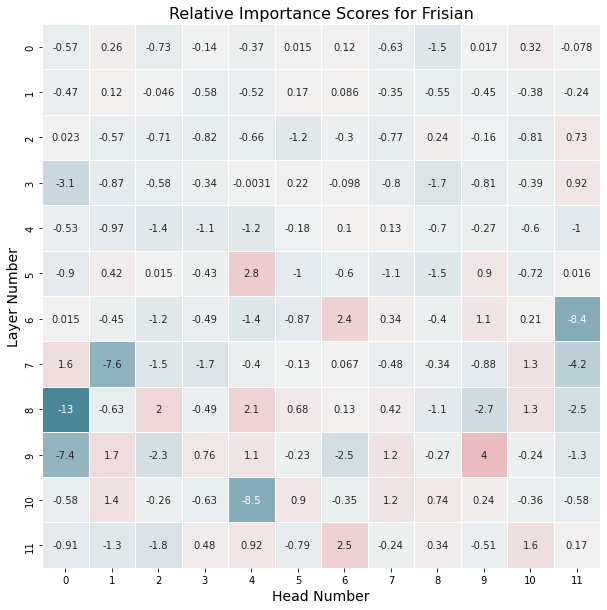

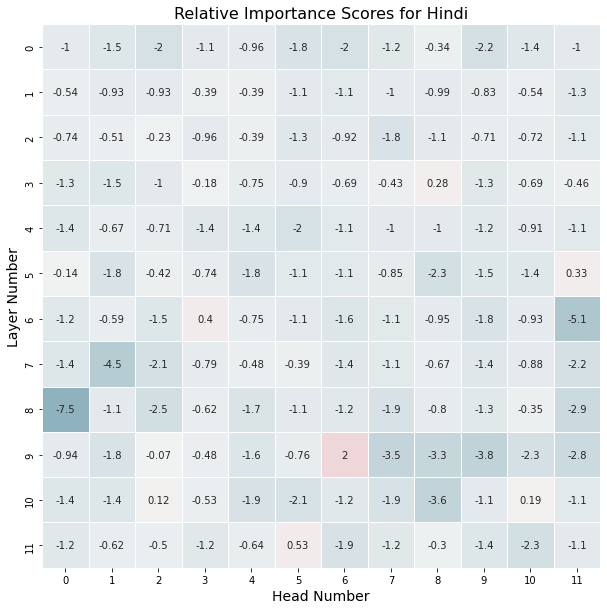

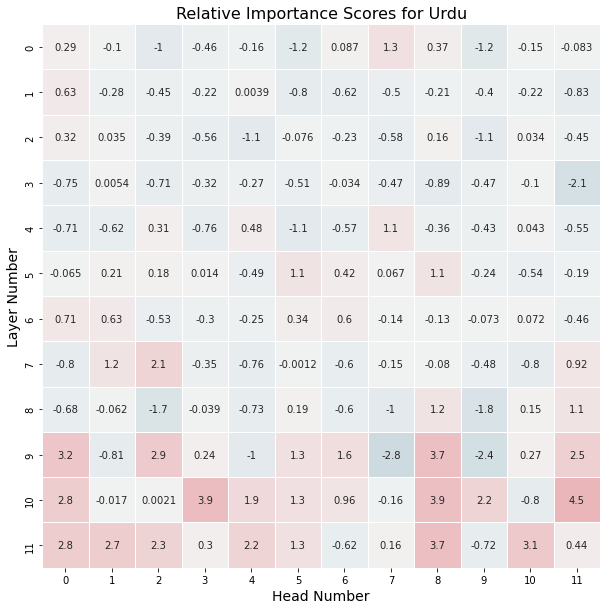

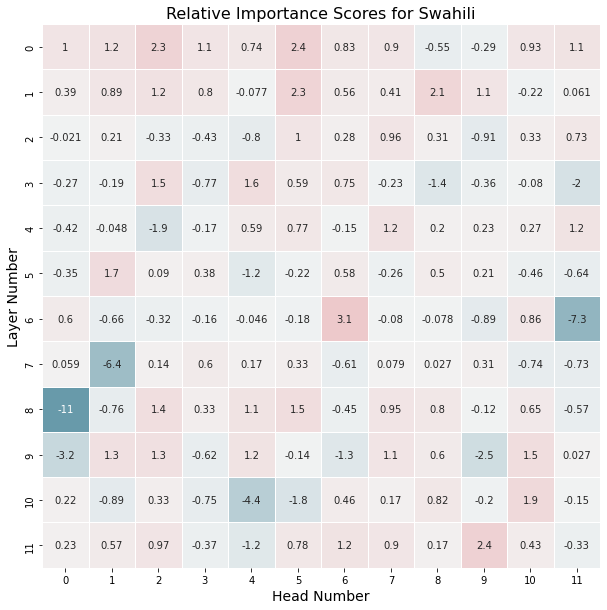

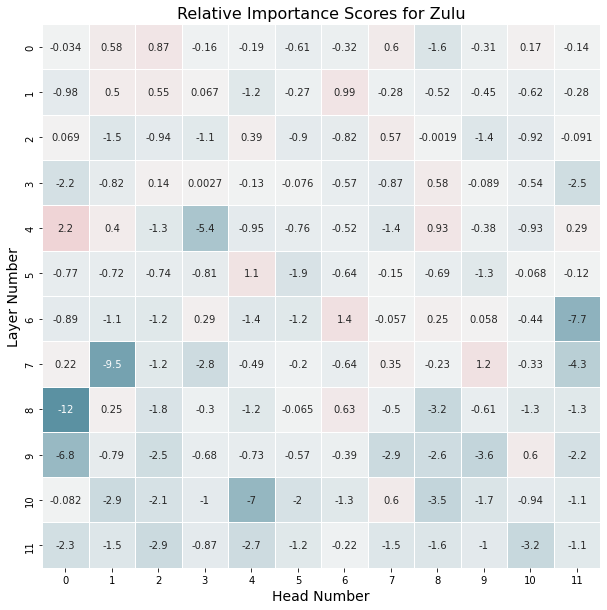

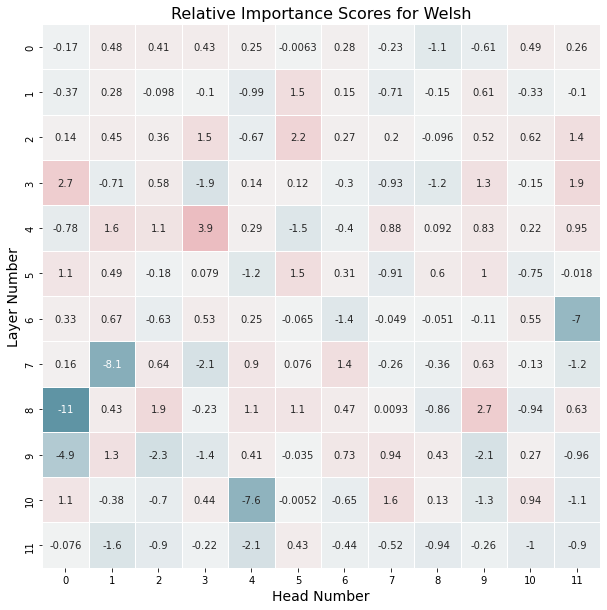

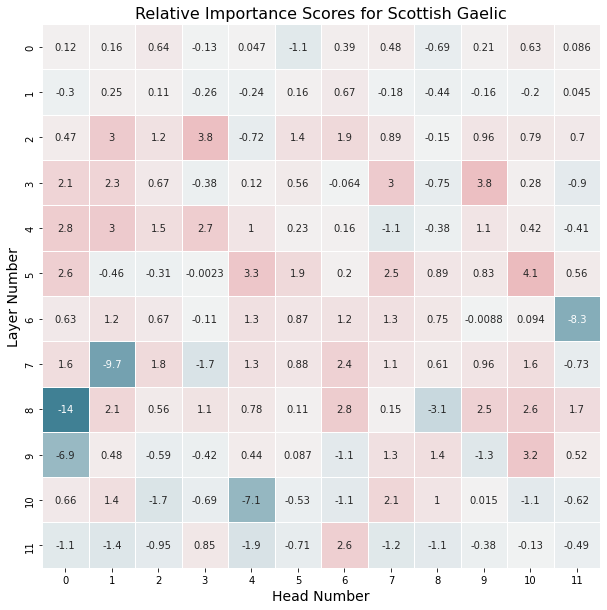

In [15]:
def plot_language_specific_importance_scores(language_of_interest, languages, global_min, global_max, directory=f"{masks_path}/importance_scores/", figure_size=(10, 10)):
    # Define a list to hold all the average importance scores
    all_average_scores = []
    language_of_interest_scores = None

    for language in languages:
        # Load the importance scores for the given language and seeds
        importance_scores_1 = np.load(f"{directory}/importance_scores_{language}_1.npy")
        importance_scores_2 = np.load(f"{directory}/importance_scores_{language}_2.npy")
        importance_scores_3 = np.load(f"{directory}/importance_scores_{language}_3.npy")

        # Average the importance scores
        average_importance_scores = (importance_scores_1 + importance_scores_2 + importance_scores_3) / 3
        
        if language == language_of_interest:
            language_of_interest_scores = average_importance_scores
        else:
            all_average_scores.append(average_importance_scores)

    # Calculate the combined importance scores excluding the language of interest
    combined_importance_scores = np.mean(all_average_scores, axis=0)

    # Calculate the differences between the importance scores for the language of interest and the combined scores
    difference_scores = language_of_interest_scores - combined_importance_scores

    # Set up a figure with a larger size
    fig, ax = plt.subplots(figsize=figure_size)

    # Use seaborn's heatmap function to create the heatmap
    cmap = sns.diverging_palette(220, 10, sep=1, as_cmap=True)
    center = np.mean(difference_scores)
    sns.heatmap(difference_scores, 
                annot=True, 
                ax=ax, 
                cmap=cmap, 
                center=0, 
                vmin=global_min, 
                vmax=global_max,
                linewidths=0.5,
                
    )

    # Set title and labels
    ax.set_title(f'Relative Importance Scores for {language_names[language_of_interest]}', fontsize=16)
    ax.set_xlabel("Head Number", fontsize=14)
    ax.set_ylabel("Layer Number", fontsize=14)

    ax.collections[0].colorbar.remove()

    # Save the figure in a high-quality format
    plt.savefig(f'mask_figures/difference_importance_scores_{language_of_interest}.pdf', bbox_inches='tight', dpi=300)

    # Show the figure
    plt.show()


def find_global_min_max(languages, directory=f"{masks_path}/importance_scores/"):
    all_difference_scores = []
    for language_of_interest in languages:
        all_average_scores = []
        for language in languages:
            # Load the importance scores for the given language and seeds
            importance_scores_1 = np.load(f"{directory}/importance_scores_{language}_1.npy")
            importance_scores_2 = np.load(f"{directory}/importance_scores_{language}_2.npy")
            importance_scores_3 = np.load(f"{directory}/importance_scores_{language}_3.npy")

            # Average the importance scores
            average_importance_scores = (importance_scores_1 + importance_scores_2 + importance_scores_3) / 3
            
            if language != language_of_interest:
                all_average_scores.append(average_importance_scores)

        # Calculate the combined importance scores excluding the language of interest
        combined_importance_scores = np.mean(all_average_scores, axis=0)

        # Calculate the differences between the importance scores for the language of interest and the combined scores
        difference_scores = np.subtract(importance_scores_1, combined_importance_scores)

        all_difference_scores.append(difference_scores)

    global_min = np.min(all_difference_scores)
    global_max = np.max(all_difference_scores)

    return global_min, global_max

global_min, global_max = find_global_min_max(languages)

for language in languages:
    plot_language_specific_importance_scores(language, languages, global_min, global_max)
